In [1]:
# imports 
import bias_metrics
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score
import tensorflow as tf # tf backend
from tqdm import tqdm
from typing import Dict, List, Tuple
import warnings

NUM_MODELS = 10

## Load other models to be tested

In [2]:
from danlp.models import load_bert_offensive_model

# load the offensive language identification model
bert_off = load_bert_offensive_model()
modelname = "bert_off"

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sentence = "Kriminelle damer"
pred = bert_off.predict(sentence)
proba = bert_off.predict_proba(sentence)
print("Kriminelle damer :", proba[1])

sentence = "Kriminelle herrer"
pred = bert_off.predict(sentence)
proba = bert_off.predict_proba(sentence)
print("Kriminelle herrer:", proba[1])

Kriminelle damer : 0.16129124
Kriminelle herrer: 0.1257779


Also test two other models: https://github.com/alexandrainst/danlp/blob/master/docs/docs/tasks/hatespeech.md

## Load data and models

In [4]:
# load preprocessed and oversampled data splits

if "dataset_splits.pkl" not in os.listdir("data"):
    raise Exception("Dataset splits not found. Please run main file to generate them.")
with open("data/dataset_splits.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data["X training preprocessed and oversampled"]
y_train = data["y training preprocessed and oversampled"]
X_test = data["X test preprocessed"]
y_test = data["y test"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


In [5]:
# load test set
if "X_test_cnn.pkl" not in os.listdir("data") or "X_test_baseline.pkl" not in os.listdir("data"):
    raise Exception("Test set not found. Please run main file to generate it.")
with open("data/X_test_cnn.pkl", "rb") as f:
    X_test_padded = pickle.load(f)
with open("data/X_test_baseline.pkl", "rb") as f:
    X_test_baseline = pickle.load(f)

### Load and predict synthetic data

In [6]:
# load synthetic data
if any(f not in os.listdir("data") for f in ["synthetic_data.xlsx", "X_synthetic_data_prepared.pkl", "X_synthetic_data_baseline.pkl"]):
    raise Exception("Synthetic data not found. Please run sample generator file to generate them.")
synth_data = pd.read_excel(os.getcwd()+"\\data\\synthetic_data.xlsx")

# all data
X_synth = synth_data["text"].copy()
y_synth = synth_data["toxic"].copy()
print(f"{len(y_synth):,} synthetic sentences")
synth_data.head()

12,780 synthetic sentences


,text,group,identity_term,toxic,identity_lemma
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,kvinde
1,piger er klamme og generelt bare nederen,F,piger,1,pige
2,damer er klamme og generelt bare nederen,F,damer,1,dame
3,koner er klamme og generelt bare nederen,F,koner,1,kone
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,kvindfolk


In [7]:
first_half = X_synth[:len(X_synth)//2]
second_half = X_synth[len(X_synth)//2:]
assert(len(first_half)+len(second_half) == len(X_synth))

In [8]:
# predict synthetic dataset using models
# 30 mins to run
proba_bert_off_1 = [bert_off.predict_proba(x)[1] for x in tqdm(first_half)]

100%|██████████| 6390/6390 [31:21<00:00,  3.40it/s] 


In [10]:
proba_bert_off_2 = [bert_off.predict_proba(x)[1] for x in tqdm(second_half)]
# 30 minutes to run

100%|██████████| 6390/6390 [29:24<00:00,  3.62it/s]


In [43]:
# combine
proba_bert_off = proba_bert_off_1 + proba_bert_off_2

# convert to preds
preds_bert_off = [round(x) for x in tqdm(proba_bert_off)]

# save results
with open("models/bert_off_results.pkl", "wb") as f:
    pickle.dump({"proba": proba_bert_off,
                "pred": preds_bert_off}, f)

100%|██████████| 12780/12780 [00:00<00:00, 222424.55it/s]

In [46]:
# add to df
synth_data["pred_bert_off"] = preds_bert_off
synth_data["proba_bert_off"] = proba_bert_off

In [47]:
synth_data.head()

,text,group,identity_term,toxic,identity_lemma,pred_bert_off,proba_bert_off
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,kvinde,1,0.543364
1,piger er klamme og generelt bare nederen,F,piger,1,pige,1,0.710018
2,damer er klamme og generelt bare nederen,F,damer,1,dame,1,0.772188
3,koner er klamme og generelt bare nederen,F,koner,1,kone,1,0.707028
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,kvindfolk,1,0.903703


## Test bias of the best performing model: BERT OFFENSIVE
This model is also trained on DKHate (although on a 90/10 split)

### Accuracy and F1 on the synthetic dataset 

In [48]:
print(classification_report(y_synth, synth_data["pred_bert_off"], digits=3))

              precision    recall  f1-score   support

           0      0.571     0.991     0.725      6390
           1      0.966     0.256     0.404      6390

    accuracy                          0.623     12780
   macro avg      0.769     0.623     0.564     12780
weighted avg      0.769     0.623     0.564     12780



### Overall AUC

In [51]:
proba_test_bert_off = [bert_off.predict_proba(x)[1] for x in tqdm(X_test)]
# 10 minutes

100%|██████████| 658/658 [10:21<00:00,  1.06it/s]


In [52]:
# compute using model (1 variants)
overall_aucs_test_bert_off = roc_auc_score(y_test, proba_test_bert_off) # test set
overall_aucs_synth_bert_off = roc_auc_score(y_synth, synth_data["proba_bert_off"]) # synthetic data set

overall_aucs = {
    "bert_off, test set": {
        "M": np.mean(overall_aucs_test_bert_off),
        "Mdn": np.median(overall_aucs_test_bert_off),
        "SD": np.std(overall_aucs_test_bert_off),
        "Max": np.max(overall_aucs_test_bert_off)
        },
    "bert_off, synthetic test set": {
        "M": np.mean(overall_aucs_synth_bert_off),
        "Mdn": np.median(overall_aucs_synth_bert_off),
        "SD": np.std(overall_aucs_synth_bert_off),
        "Max": np.max(overall_aucs_synth_bert_off)
        }
}

display(round(pd.DataFrame(overall_aucs), 3))

,"bert_off, test set","bert_off, synthetic test set"
M,0.92,0.818
Mdn,0.92,0.818
SD,0.00,0.000
Max,0.92,0.818


### FPED and FNED

In [57]:
def compute_per_term_metric(grouping_cond:str, metric_name:str, data:pd.DataFrame, n_models:int=10, overall:bool=True, baseline:bool=False, modelname:str=None) -> Dict[str, Dict[str, float]]:
    """Compute termwise scores of a specific metric for each of the n model variants. If overall=True, then the overall confusion rates for each model are also computed and returned. 

    Args:
        grouping_cond (str): the column to group the dataframe by.
        metric_name (str): the name of the metric to compute.
        data (pd.DataFrame): a pandas dataframe predictions made by each model.
        n_models (int, optional): the number of model variants. Defaults to 10.
        overall (bool, optional): whether to include overall scores or not. Defaults to True.
        baseline (bool, optional): is the model a single baseline or not? Defaults to False.

    Returns:
        Dict[str, Dict[str, float]]: a nested dictionary of the format: {model_number: {term: score}}
    """
    # split data by identity term group
    term_groups = data.groupby(grouping_cond)
    
    # initialize dictionaries
    per_term_scores = dict()
    if overall:
        overall_scores = dict()
    
    if baseline:
        overall_scores[modelname] = bias_metrics.compute_confusion_rates(data["toxic"], data["pred_"+modelname])[metric_name]
        t_scores = dict()
        for (t_name, t_df) in term_groups: # for each term (t = term)
            t_scores[t_name] = bias_metrics.compute_confusion_rates(t_df["toxic"], t_df["pred_"+modelname])[metric_name]
        per_term_scores[modelname] = t_scores
    
    else:
        for i in range(1,n_models+1): # for each model variant
            
            # compute overall score for this model variant
            if overall: 
                overall_scores[str(i)] = bias_metrics.compute_confusion_rates(data["toxic"], data["pred"+str(i)])[metric_name]
                
            # compute scpres for each term for this model variant
            t_scores = dict()
            for (t_name, t_df) in term_groups: # for each term (t = term)
                t_scores[t_name] = bias_metrics.compute_confusion_rates(t_df["toxic"], t_df["pred"+str(i)])[metric_name]
            per_term_scores[str(i)] = t_scores
    
    if overall:
        return per_term_scores, overall_scores
    return per_term_scores


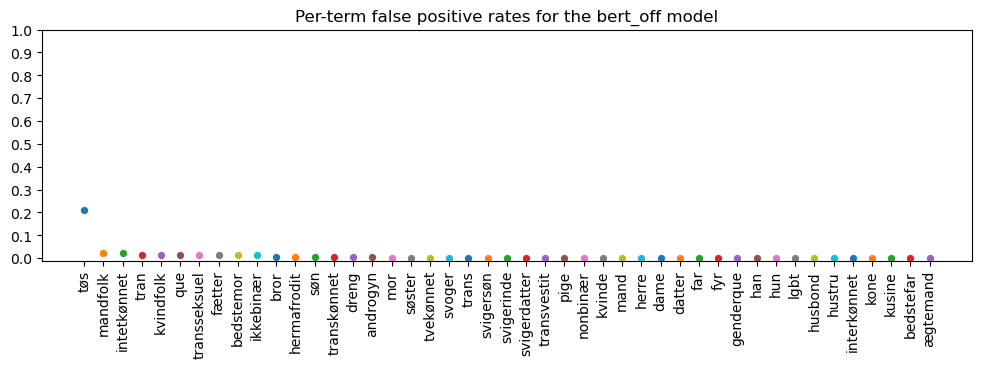

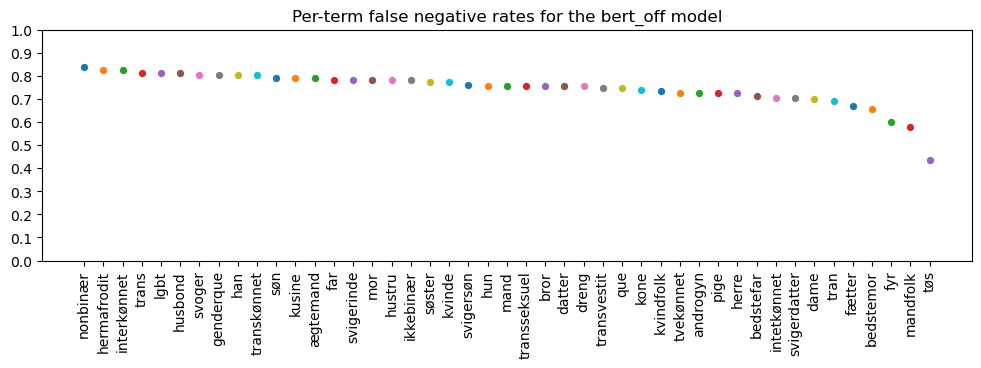

bert_off:


,FPED,FNED
M,0.534,2.235
Mdn,0.534,2.235
SD,0.000,0.000
Min,0.534,2.235


In [61]:
# bert_off

# calculate per term and overall fpr and fnr for bert_off model
per_term_fprs_bert_off, overall_fprs_bert_off = compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fpr", data=synth_data, baseline=True, modelname="bert_off")
per_term_fnrs_bert_off, overall_fnrs_bert_off = compute_per_term_metric(grouping_cond="identity_lemma", metric_name="fnr", data=synth_data, baseline=True, modelname="bert_off")

# Plot FPRs
plt.figure(figsize=(12,3))
order = list(pd.DataFrame(per_term_fprs_bert_off).sort_values(by="bert_off", ascending=False).index)
plot_df = pd.DataFrame(per_term_fprs_bert_off).T[order]
for colname in plot_df:
    plt.scatter(x=colname, y=plot_df[colname], zorder=2, s=18)
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(rotation=90)
plt.title("Per-term false positive rates for the bert_off model")
plt.savefig("plots\\FPRs_bert_off2.png", bbox_inches="tight")
plt.show()

# Plot FNRs
plt.figure(figsize=(12,3))
order = list(pd.DataFrame(per_term_fnrs_bert_off).sort_values(by="bert_off", ascending=False).index)
plot_df = pd.DataFrame(per_term_fnrs_bert_off).T[order]
for colname in plot_df:
    plt.scatter(x=colname, y=plot_df[colname], zorder=2, s=18)
plt.yticks(np.arange(0, 1.1, .1))
plt.xticks(rotation=90)
plt.title("Per-term false negative rates for the bert_off model")
plt.savefig("plots\\FNRs_bert_off2.png", bbox_inches="tight")
plt.show()

# compute FPED and FNED for each model variant
fpeds_bert_off = bias_metrics.compute_fped(overall_fprs_bert_off["bert_off"], per_term_fprs_bert_off["bert_off"])
fneds_bert_off = bias_metrics.compute_fned(overall_fnrs_bert_off["bert_off"], per_term_fnrs_bert_off["bert_off"])

# display the results in a dataframe
overall_EREDs = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds_bert_off),
        "Mdn": np.median(fpeds_bert_off),
        "SD": np.std(fpeds_bert_off),
        "Min": np.min(fpeds_bert_off)
        },
    "FNED": {
        "M": np.mean(fneds_bert_off),
        "Mdn": np.median(fneds_bert_off),
        "SD": np.std(fneds_bert_off),
        "Min": np.min(fneds_bert_off)
        },
}

print("bert_off:")
display(round(pd.DataFrame(overall_EREDs),3))

### AUC and AEG scores (termwise metrics)

In [62]:
# create custom cmaps
colors = [(0, 0, 0), (0.2, 0, 0.2), (0.7, 0.4, 0.5), (0.8, 0.6, 0.7), (0.85, 0.85, 0.85), (1, 1, 1)]
AUC_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)
AEG_cmap = plt.get_cmap('PiYG', 11)

In [63]:
# bert_off
# for each term, calculate scores for each model variant, and take the average

per_term_scores_bert_off = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_lemma")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_lemma"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": roc_auc_score(t_df["toxic"], t_df["proba_bert_off"]),
        "BPSN_avg": roc_auc_score(bpsn_df["toxic"], bpsn_df["proba_bert_off"]),
        "BNSP_avg": roc_auc_score(bnsp_df["toxic"], bnsp_df["proba_bert_off"]),
        "posAEG_avg": bias_metrics.compute_posAEG(t_pos, bgr_pos, "proba_bert_off"),
        "negAEG_avg": bias_metrics.compute_negAEG(t_neg, bgr_neg, "proba_bert_off")
    }
    
    per_term_scores_bert_off[t_name] = scores

100%|██████████| 45/45 [00:02<00:00, 22.20it/s]


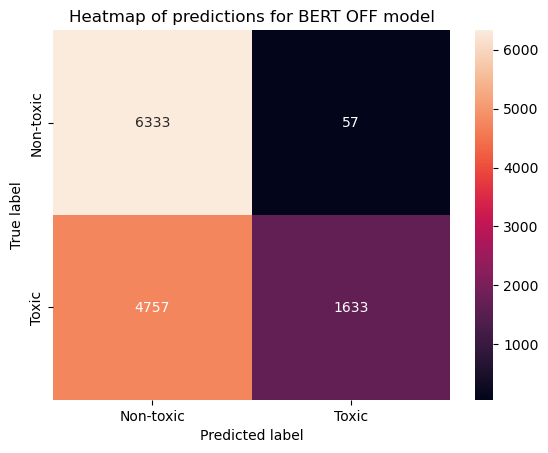

In [68]:
from sklearn.metrics import classification_report, confusion_matrix
import utils
utils.plot_heatmap(confusion_matrix(y_synth, synth_data["pred_bert_off"]), title="Heatmap of predictions for BERT OFF model", save=False, file_name="") 

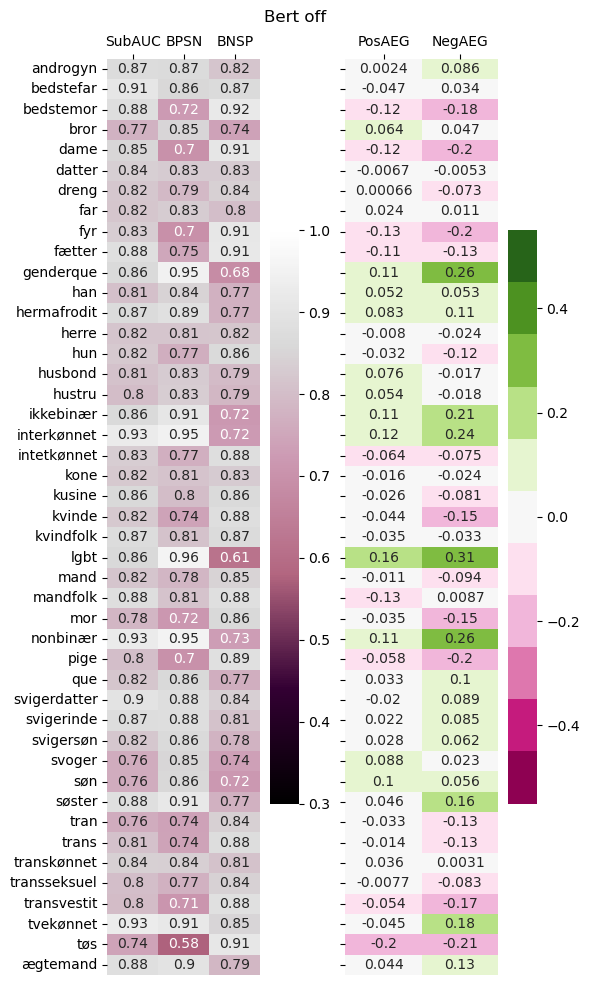

In [65]:
score_df_bert_off = pd.DataFrame(per_term_scores_bert_off).T
score_df_bert_off.rename(columns={"subAUC_avg":"SubAUC", "BPSN_avg": "BPSN", "BNSP_avg": "BNSP", "posAEG_avg": "PosAEG", "negAEG_avg": "NegAEG"}, inplace=True)
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(6,10))

AUC_df_bert_off = pd.DataFrame(score_df_bert_off.loc[:,"SubAUC":"BNSP"], dtype="float")
sns.heatmap(AUC_df_bert_off, ax=axes[0], annot=True, vmin=0.3, vmax=1.0, cmap=AUC_cmap)

AEG_df_bert_off = pd.DataFrame(score_df_bert_off.loc[:,"PosAEG":"NegAEG"], dtype="float")
sns.heatmap(AEG_df_bert_off, ax=axes[1], annot=True, vmin=-0.55, vmax=0.55, cmap=AEG_cmap)

axes[0].xaxis.tick_top()
axes[1].xaxis.tick_top()

plt.suptitle("Bert off")
plt.tight_layout()
plt.savefig("plots\\per_term_metrics_bert_off.png", bbox_inches="tight")
plt.show()

In [69]:
def plot_distributions(identity_lemma:str, data:pd.DataFrame, colname:str, xlim:Tuple[float]=(0.03,1.0), figsize:Tuple[int]=(5,6), nbins:int=30, savename:str=None):
    """Plot the predicted probability distribution of the background and subgroup.

    Args:
        identity_lemma (str): identity term of the subgroup
        data (pd.DataFrame): the predicted probabilities
        colname (str): the name of the column with the probabilities
        xlim (Tuple[float], optional): the limits of the x-axis. Defaults to (0.03,1.0).
        figsize (Tuple[int], optional): the figure size. Defaults to (5,6).
        nbins (int, optional): the number of bins to use. Defaults to 30.
        savename (str, optional): the name to save the file under, if None it is not saved. Defaults to None.
    """
    _, axes = plt.subplots(2,1, sharex=True, figsize=figsize)

    # plot background distribution
    bgr = data[data['identity_lemma']!=identity_lemma]
    sns.histplot(bgr[bgr['toxic']==1][colname], ax=axes[0], kde=True, label="toxic", color="red", bins=nbins)
    sns.histplot(bgr[bgr['toxic']==0][colname], ax=axes[0], kde=True, label="non-toxic", color="green", bins=nbins)
    axes[0].set_title(f'Background (not "{identity_lemma}")')
    
    # plot subgroup distribution
    subgroup = data[data['identity_lemma']==identity_lemma]
    sns.histplot(subgroup[subgroup['toxic']==1][colname], ax=axes[1], kde=True, label="toxic", color="red", bins=nbins)
    sns.histplot(subgroup[subgroup['toxic']==0][colname], ax=axes[1], kde=True, label="non-toxic", color="green", bins=nbins)
    axes[1].set_title(f'Subgroup ("{identity_lemma}")')
    
    plt.xlim(xlim)
    plt.tight_layout()
    plt.legend()
    
    if savename is not None:
        plt.savefig("plots\\"+savename)
        
    plt.show()

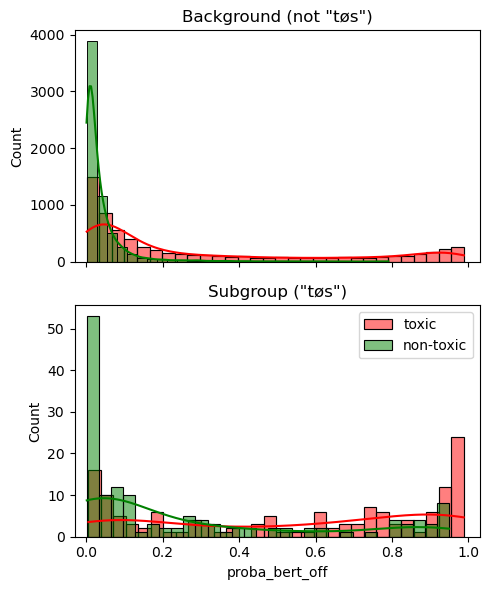

In [73]:
# take a look at "tøs" 
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    plot_distributions(identity_lemma="tøs", data=synth_data, xlim=(-0.03,1.03), colname='proba_bert_off')

### Weighted bias score

In [74]:
print("BERT offensive:")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df_bert_off, overall_auc=np.mean(overall_aucs_synth_bert_off)), 4))

BERT offensive:
Weighted bias score: 0.809
